## Polos desejados

G_z = 
 0.02335 z^2 + 0.05599 z + 0.007465
------------------------------------
z^3 - 1.758 z^2 + 0.9436 z - 0.09924

dt = 0.003105590062111801

zeros: [-2.25584601 -0.14169737]
polos: [0.8098819 +0.25402708j 0.8098819 -0.25402708j 0.13775321+0.j        ]


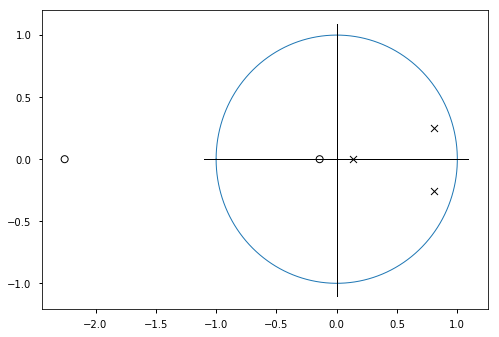

In [232]:
G_z = c2d(G_s, Ts)
print(f'G_z = {G_z}')
zplane(G_z)
print(f'zeros: {zero(G_z)}')
print(f'polos: {pole(G_z)}')

4 states have been removed from the model

      0.02335 z
----------------------
z^2 - 1.138 z + 0.1378

dt = 0.003105590062111801



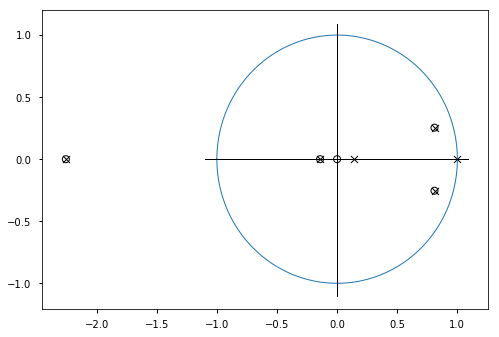

In [288]:
z = zero(G_z)
p = pole(G_z)
Gc_z = tf(np.poly([p[0], p[1]]), np.poly([z[0], z[1]]), Ts) * integrador
print(minreal(Gc_z * G_z))
zplane(Gc_z * G_z)
# zplane(minreal(Gc_z * G_z), color='red')

[1.]


{'RiseTime': 0.003105590062111801,
 'SettlingTime': 0.012422360248447204,
 'SettlingMin': 0.9983174176926838,
 'SettlingMax': 1.0442429106633007,
 'Overshoot': 4.424291066330217,
 'Undershoot': 0.0,
 'Peak': 1.0442429106633007,
 'PeakTime': 0.009316770186335404,
 'SteadyStateValue': 0.9999999999999986}

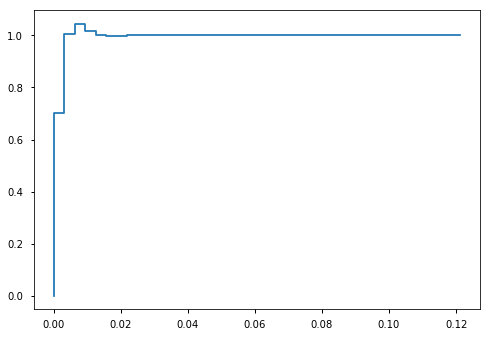

In [294]:
# k = 37.92281569321959
k = 30
yout, T = step(k * ((Gc_z * G_z) / (1 + k*(Gc_z * G_z))), T)
plt.step(T, yout)
print(yout[-1])
# zplane(k * ((Gc_z * G_z) / (1 + (Gc_z * G_z))))
stepinfo(k * ((Gc_z * G_z) / (1 + k*(Gc_z * G_z))))

Localizando onde queremos que esteja o pólo dominnante de malha fechada no plano Z:

Pólo P1 -> [0.6865999331251057, 39.93910071578851°]
Pólo P1 -> (0.5264348612309636+0.44077863497240394j)
Pólo P2 -> (1+0j)

          1
----------------------
z^2 - 1.053 z + 0.4714

dt = 0.003105590062111801



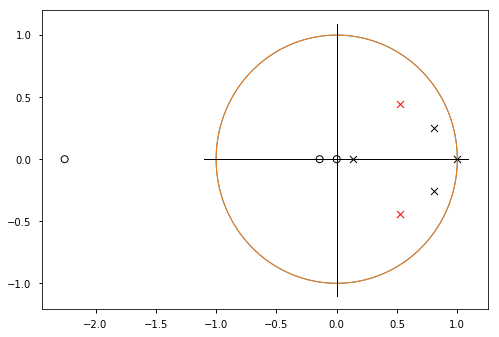

In [165]:
# Representação polar
p1_r = np.exp(-Ts * zeta * wn)
p1_theta = np.degrees(Ts * wd)
print(f'Pólo P1 -> [{p1_r}, {p1_theta}°]')

# Representação retangular
p1 = p1_r * np.exp(1j * np.radians(p1_theta))
print(f'Pólo P1 -> {p1}')
p2 = 1 +0j
print(f'Pólo P2 -> {p2}')

local_polos = tf(1, np.poly([p1, p1.conjugate()]), Ts)
# local_polos = tf(np.poly([p1, p1.conjugate()]), 1, Ts)
print(local_polos)

zplane(local_polos, color='red')
zplane(G_z)

Identificamos os seus polos e zeros:

In [35]:
print(f'polos: {pole(G_z)}')
print(f'zeros: {zero(G_z)}')

polos: [1.        +0.j         0.8098819 +0.25402708j 0.8098819 -0.25402708j
 0.13775321+0.j        ]
zeros: [-2.25584601 -0.14169737  0.        ]


Para que $Z_1$ seja o lugar das raízes, a soma dos ângulos de polos e zeros em relação à $Z_1$ deve ser igual a $\pm$ 180°:

In [212]:
# G_z * tf(np.poly([p1, p1.conjugate()]), [1, 0], Ts)
poles = pole(G_z)
zeros = zero(G_z)

angle_sum = 0
for p in poles:
    angle_sum += control.unwrap([-np.angle(p1 -p, deg=True)], period=360)[0]
    
for z in zeros:
    angle_sum += control.unwrap([np.angle(p1 -z, deg=True)], period=360)[0]

print(f'Somatório dos ângulos: {angle_sum}°')

# angle_needed = angle_sum + 180
angle_needed = 0

print(f'Ângulo que o controlador deve fornecer: {angle_needed}°')

Somatório dos ângulos: -362.1065726912745°
Ângulo que o controlador deve fornecer: 0°


In [213]:
print(f'Polos = {pole(G_z)}')

Polos = [1.        +0.j         0.8098819 +0.25402708j 0.8098819 -0.25402708j
 0.13775321+0.j        ]


Considerando a planta do controlador como:

$$ G_D(z) = K\,\frac{(z+\alpha)(z+\alpha^*)}{(z-1)(z+\beta)} $$

Onde K é o ganho do controlador, $-\alpha$ é o zero e $-\beta$ é o polo.

Se decidirmos cancelar o pólo em $Z = 0,67... $ colocando o zero do controlador em $Z = 0,67...$, temos $\alpha = -0,67...$:

In [214]:
alpha = -pole(G_z)[1]
print(f'a = {alpha}')

a = (-0.8098818972870269-0.2540270757280864j)


Então o pólo do controlador pode ser determinado a partir da condição do ângulo que ele deve fornecer:

In [215]:
# Considerando dois triângulos retângulos podemos:
theta = angle_needed
theta1 = np.degrees(np.arctan((poles[1].real -p1.real) / (poles[1].imag - p1.imag)))
theta2 = theta - theta1
beta = -(np.tan(np.radians(theta2)) * (p1.imag) + p1.real)
print(f'b = {beta}')

b = -1.1954380981801989


Gd(z)/k = 
z^2 - 1.62 z + 0.7204
---------------------
    z^2 - 1.195 z

dt = 0.003105590062111801



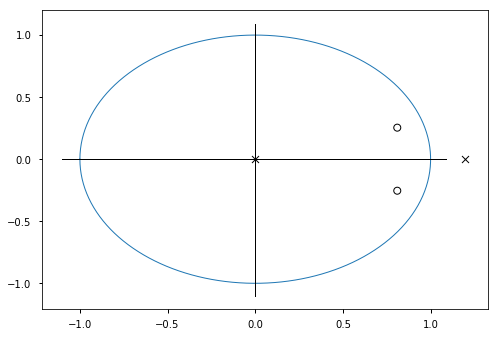

In [225]:
# Gd_z_over_k = tf(np.poly([-alpha, -alpha.conjugate()]), np.poly([-beta]), Ts) * integrador
Gd_z_over_k = tf(np.poly([-alpha, -alpha.conjugate()]), np.poly([0, -beta]), Ts)
print(f'Gd(z)/k = {Gd_z_over_k}')
zplane(Gd_z_over_k)

O ganho $K$ pode ser determinado pela condição de módulo:

$$ |G_D(z) * G(z)|_{z = z1} = 1 $$

In [217]:
FTMA_over_k = Gd_z_over_k * G_z
print(f'FTMA(z)/k = {FTMA_over_k}')
print(f'P1 = {p1}')

k = abs(np.polyval(*FTMA_over_k.den[0], p1) / np.polyval(*FTMA_over_k.num[0], p1))
print(f'k = {k}')

FTMA(z)/k = 
0.02335 z^5 + 0.01816 z^4 - 0.0664 z^3 + 0.02825 z^2 + 0.005378 z
-----------------------------------------------------------------
    z^5 - 3.953 z^4 + 5.998 z^3 - 4.272 z^2 + 1.346 z - 0.1186

dt = 0.003105590062111801

P1 = (0.5264348612309636+0.44077863497240394j)
k = 8.42517988164137


In [218]:
Gd_z = k * Gd_z_over_k
print(f'Gd(z) = {Gd_z}')
FTMA = Gd_z * G_z
print(f'FTMA(z) = {FTMA}')

Gd(z) = 
8.425 z^2 - 13.65 z + 6.07
--------------------------
        z - 1.195

dt = 0.003105590062111801

FTMA(z) = 
0.1968 z^5 + 0.153 z^4 - 0.5594 z^3 + 0.238 z^2 + 0.04531 z
-----------------------------------------------------------
z^5 - 3.953 z^4 + 5.998 z^3 - 4.272 z^2 + 1.346 z - 0.1186

dt = 0.003105590062111801



FTMF(z) = 
0.1968 z^10 - 0.6247 z^9 + 0.01567 z^8 + 2.527 z^7 - 4.64 z^6 + 3.821 z^5 - 1.516 z^4 + 0.1931 z^3 + 0.03275 z^2 - 0.005375 z
------------------------------------------------------------------------------------------------------------------------------
1.197 z^10 - 8.531 z^9 + 27.64 z^8 - 53.43 z^7 + 67.79 z^6 - 58.3 z^5 + 33.81 z^4 - 12.73 z^3 + 2.858 z^2 - 0.3247 z + 0.01408

dt = 0.003105590062111801



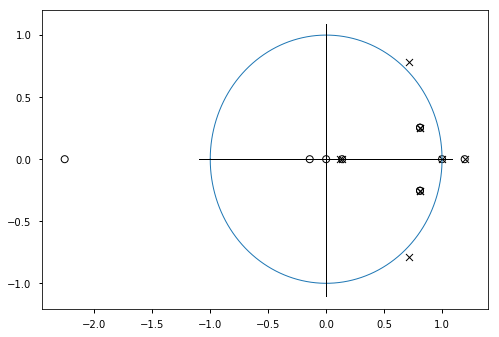

In [219]:
FTMF = (FTMA / (1 + FTMA))
print(f'FTMF(z) = {FTMF}')

zplane(FTMF)

7 states have been removed from the model
FTMF(z) = 
0.1644 z^3 + 0.3942 z^2 + 0.05255 z
-----------------------------------
z^3 - 1.555 z^2 + 1.304 z - 0.1376

dt = 0.003105590062111801



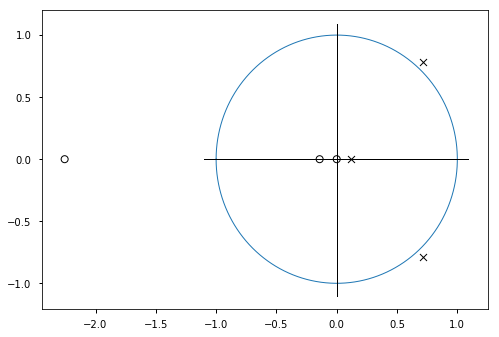

In [220]:
FTMF = minreal(FTMF)
print(f'FTMF(z) = {FTMF}')

zplane(FTMF)

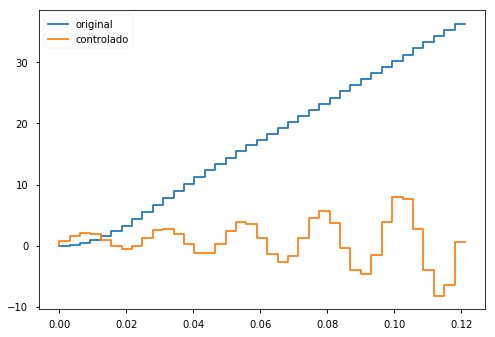

In [221]:
final_time = 5*Req['SettlingTime']
T = np.arange(final_time / Ts) * Ts
yout, T = step(G_z, T)
plt.step(T, yout)
yout, T = step(FTMF, T)
plt.step(T, yout)
plt.legend(['original', 'controlado'])

In [222]:
print('\n-> Sem controlador:')
print(json.dumps(S, indent=4))
print('\n-> Com controlador:')
FTMF_info = stepinfo(FTMF)
print(json.dumps(FTMF_info, indent=4))
print('\n-> Requisitos:')
print(json.dumps(Req, indent=4))


-> Sem controlador:
{
    "RiseTime": 0.014733110889278787,
    "SettlingTime": 0.04955682753666501,
    "SettlingMin": 0.9474371557000978,
    "SettlingMax": 1.1805086179959798,
    "Overshoot": 18.178443153933472,
    "Undershoot": 0.0,
    "Peak": 1.1805086179959798,
    "PeakTime": 0.03348434293017906,
    "SteadyStateValue": 0.9989204346331648
}

-> Com controlador:


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
t = np.arange(-np.pi, np.pi, 0.01)
ax = np.arange(-1.1, 1.1, 0.01)
plt.plot(np.cos(t), np.sin(t), lw=1)
plt.plot(ax, ax * 0, color='black', lw=1)
plt.plot(ax * 0, ax, color='black', lw=1)
plt.scatter(p1.real, p1.imag, marker='x', lw=1, color='red')
plt.text(p1.real, p1.imag, 'P1')
plt.scatter(p1.real, -p1.imag, marker='x', lw=1, color='red')
plt.text(p1.real, -p1.imag, 'P1*')
plt.scatter(p2.real, p2.imag, marker='x', lw=1, color='red')
plt.text(p2.real, p2.imag, 'P2')

poles = pole(FTMF)
zeros = zero(FTMF)

for p in poles:
    plt.scatter(p.real, p.imag, marker='x', color='black', lw=1)
for z in zeros:
    plt.scatter(z.real, z.imag, marker='o', facecolors='none', color='black', lw=1)